# Diabetes prediction using Decision Tree Algorithm

## 1. Import modules 

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

import configuration as config
import functions as funcs

## 2. Data preparation
### 2.1. Data download 

In [2]:
data_url='https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
data_df=pd.read_csv(data_url)
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 2.2. Inspect the data frame 

In [3]:
data_df.head().T

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### 2.3. Test-train split 

In [5]:
training_df, testing_df=train_test_split(data_df,test_size=0.25,random_state=315)

## 3. EDA 
### 3.1. Basic model performance 

In [6]:
training_df['Outcome'].value_counts()

Outcome
0    377
1    199
Name: count, dtype: int64

Constant "No" Model 

In [7]:
# Accuracy for constant '0' model
accuracy_model=((len(testing_df) - sum(testing_df['Outcome'])) / len(testing_df))*100
print(f'Testing accuracy of constant "0" model: {accuracy_model:.1f}%')


Testing accuracy of constant "0" model: 64.1%


Accuracy of a YES model 

In [ ]:
#yes_accuracy=(sum((training_df['Outcome']))/(len(training_df)))*100
#yes_accuracy
#print(f'Testing accuracy of constant "1" model: {yes_accuracy:.1f}%')

34.54861111111111

Logistic Regression model

In [12]:
logistic = LogisticRegression(max_iter=5000)
logistic.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy_LR_model=accuracy_score(logistic.predict(testing_df.drop('Outcome', axis=1)), testing_df["Outcome"])*100
print(f"The accuracy of a logistic regression model is: {accuracy_LR_model:.2f}%")


The accuracy of a logistic regression model is: 77.60%


### 3.2. Feature distributions and cleaning 

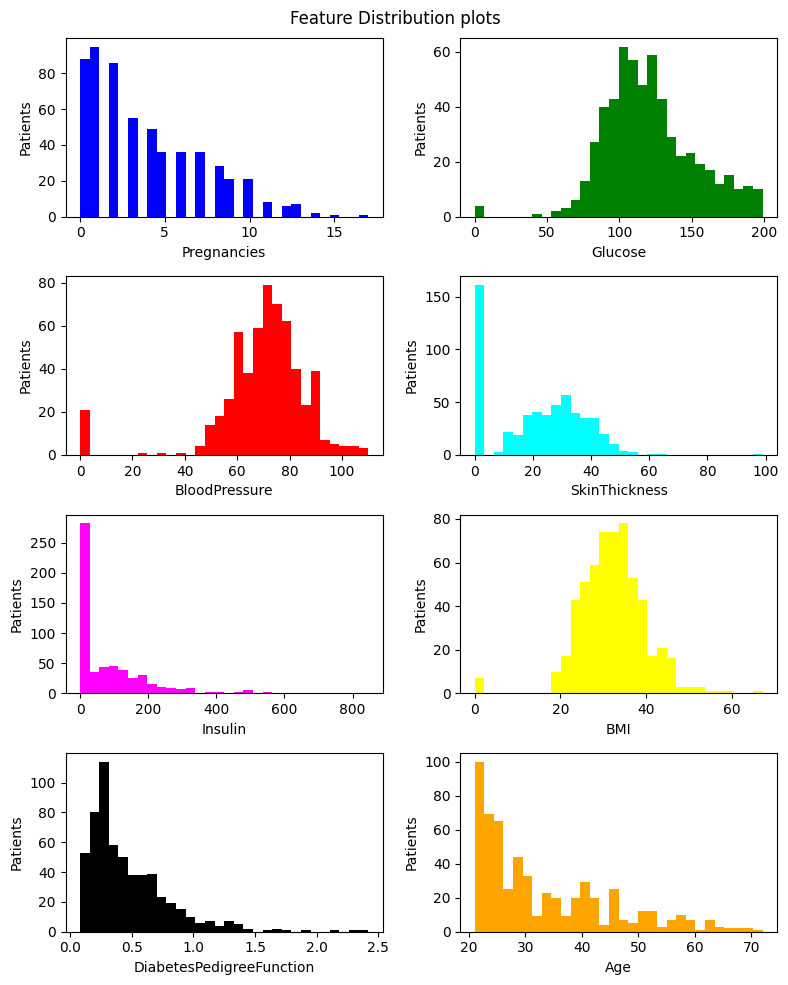

In [ ]:
numerical_features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig,axs=plt.subplots(4, 2, figsize=(8, 10))
axs=axs.flatten()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

fig.suptitle('Feature Distribution plots')

for i, feature in enumerate(numerical_features):
    axs[i].hist(training_df[feature], color=colors[i%len(colors)], bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Number of Patients')

fig.tight_layout()